In [23]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
file_path = "/Users/miladutton/Desktop/CSS/Python/AiText/ai_vs_human_text.csv" 
df_uploaded = pd.read_csv(file_path)

df_uploaded.head()


,id,text,label,prompt,model,date
0,1,AI-generated content sample 1: This is an exam...,AI-generated,Explain the benefits of deep learning.,ChatGPT,2023-11-25
1,2,AI-generated content sample 2: This is an exam...,AI-generated,Write an article on the future of AI.,Bard,2024-11-15
2,3,Human-written text sample 3: This is an exampl...,Human-written,Editorial on the impact of technology in society.,Human,2024-08-11
3,4,AI-generated content sample 4: This is an exam...,AI-generated,Describe how neural networks work.,Claude,2024-04-27
4,5,Human-written text sample 5: This is an exampl...,Human-written,Personal essay on learning programming.,Human,2024-08-15


In [26]:
# clean
df = df_uploaded[['text', 'label']].copy()

# map labels
df['label'] = (
    df['label']
    .astype(str).str.strip().str.lower()
    .map({'ai-generated': 'ai', 'human-written': 'human', 'ai':'ai', 'human':'human'})
)

# drop 
df = df.dropna(subset=['text','label'])
df['text'] = df['text'].astype(str).str.strip()
df = df[df['text'].str.len() >= 5]

print("Class balance:\n", df['label'].value_counts())
print("Shape:", df.shape)
assert df['label'].nunique() == 2, "Need both classes present."

Class balance:
 label
ai       507
human    493
Name: count, dtype: int64
Shape: (1000, 2)


In [27]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)
print(f"Train/Test sizes: {len(X_train)} / {len(X_test)}")



Train/Test sizes: 800 / 200


In [28]:
# baseline models
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=500))
])

pipe_svc = Pipeline([
    ("tfidf", TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2), min_df=2)),
    ("clf", LinearSVC())
])

pipe_lr.fit(X_train, y_train)
pipe_svc.fit(X_train, y_train)

print("\nAccuracy (train/test)")
print("  LogisticRegression:", round(pipe_lr.score(X_train, y_train), 3), "/", round(pipe_lr.score(X_test, y_test), 3))
print("  LinearSVC        :", round(pipe_svc.score(X_train, y_train), 3), "/", round(pipe_svc.score(X_test, y_test), 3))




Accuracy (train/test)
  LogisticRegression: 1.0 / 1.0
  LinearSVC        : 1.0 / 1.0



=== Logistic Regression ===
              precision    recall  f1-score   support

          ai      1.000     1.000     1.000       101
       human      1.000     1.000     1.000        99

    accuracy                          1.000       200
   macro avg      1.000     1.000     1.000       200
weighted avg      1.000     1.000     1.000       200



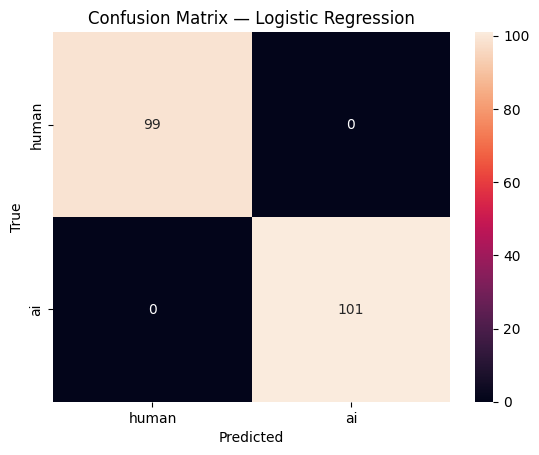


=== Linear SVC ===
              precision    recall  f1-score   support

          ai      1.000     1.000     1.000       101
       human      1.000     1.000     1.000        99

    accuracy                          1.000       200
   macro avg      1.000     1.000     1.000       200
weighted avg      1.000     1.000     1.000       200



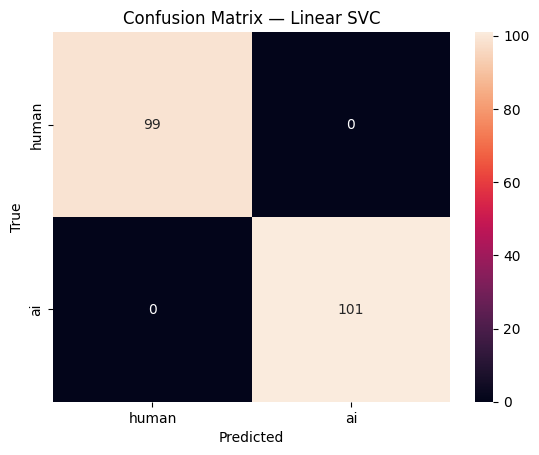

In [29]:
# evaluation helper
def evaluate(model, X_te, y_te, title):
    preds = model.predict(X_te)
    print(f"\n=== {title} ===")
    print(classification_report(y_te, preds, digits=3))
    cm = confusion_matrix(y_te, preds, labels=["human","ai"])
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=["human","ai"], yticklabels=["human","ai"])
    plt.title(f"Confusion Matrix — {title}")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.show()

evaluate(pipe_lr,  X_test, y_test, "Logistic Regression")
evaluate(pipe_svc, X_test, y_test, "Linear SVC")


In [31]:
# tuning
grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__C": [0.25, 1.0, 2.0, 4.0],
}
gs = GridSearchCV(pipe_svc, grid, scoring="accuracy", cv=5, n_jobs=-1)
gs.fit(X_train, y_train)

print("\nBest CV:", round(gs.best_score_, 4))
print("Best params:", gs.best_params_)
print("Test acc (best):", round(gs.best_estimator_.score(X_test, y_test), 4))

best_model = gs.best_estimator_


Best CV: 1.0
Best params: {'clf__C': 0.25, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Test acc (best): 1.0


In [ ]:
# top n grams
vect = best_model.named_steps["tfidf"]
clf  = best_model.named_steps["clf"]

feature_names = np.array(vect.get_feature_names_out())
coefs = clf.coef_[0]
classes = clf.classes_
print("Classes order:", classes)

top_pos = np.argsort(coefs)[-15:][::-1]  # toward classes[1]
top_neg = np.argsort(coefs)[:15]         # toward classes[0]

print(f"\nTop n-grams → {classes[1]}:\n", list(zip(feature_names[top_pos], np.round(coefs[top_pos], 3))))
print(f"\nTop n-grams → {classes[0]}:\n", list(zip(feature_names[top_neg], np.round(coefs[top_neg], 3))))

Classes order: ['ai' 'human']

Top n-grams → human:
 [('written', np.float64(1.229)), ('human', np.float64(1.229)), ('interview', np.float64(0.38)), ('researcher', np.float64(0.38)), ('text', np.float64(0.357)), ('essay', np.float64(0.285)), ('personal', np.float64(0.285)), ('programming', np.float64(0.285)), ('report', np.float64(0.234)), ('conference', np.float64(0.234)), ('industry', np.float64(0.234)), ('society', np.float64(0.212)), ('impact', np.float64(0.212)), ('editorial', np.float64(0.212)), ('technology', np.float64(0.212))]

Top n-grams → ai:
 [('generated', np.float64(-1.217)), ('content', np.float64(-0.609)), ('ai', np.float64(-0.471)), ('neural', np.float64(-0.306)), ('work', np.float64(-0.306)), ('networks', np.float64(-0.306)), ('deep', np.float64(-0.288)), ('explain', np.float64(-0.288)), ('benefits', np.float64(-0.288)), ('claude', np.float64(-0.282)), ('chatgpt', np.float64(-0.278)), ('gpt', np.float64(-0.277)), ('bard', np.float64(-0.272)), ('article', np.float64(-

In [35]:
#finalize
joblib.dump(best_model, "ai_human_text_detector.joblib")
print("\nSaved model → ai_human_text_detector.joblib")

def predict_text(txt: str):
    mdl = joblib.load("ai_human_text_detector.joblib")
    return mdl.predict([txt])[0]

print("\nSample prediction:", predict_text("In this essay, we will carefully explore the multifaceted dimensions of innovation across history."))



Saved model → ai_human_text_detector.joblib

Sample prediction: human
